# Behavioral analyses

Extract behaviorally relevant data from the `events.tsv` files and provide them in Pandas dataframe format.

In [1]:
%matplotlib inline

In [2]:
import itertools
import os
import os.path as op
import shutil
from tempfile import mkdtemp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin
import seaborn as sns
import scipy
from scipy import stats

from utils import (
    BIDS_ROOT,
    TASK_NAME_MAP,
    events_to_behav_data,
    task_not_present_for_subject,
    get_df_bnt,
    add_binned_outcomes_to_df,
)

# Get sample description

In [3]:
participants_tsv = op.join(BIDS_ROOT, "participants.tsv")
participants_tsv = pd.read_csv(participants_tsv, sep="\t")

nsubjs = len(participants_tsv)
nfemale = int((participants_tsv["sex"] == "f").sum())
mean_age = participants_tsv["age"].mean().round(1)
sd_age = participants_tsv["age"].std().round(1)
age_range = (participants_tsv["age"].min(), participants_tsv["age"].max())

print(f"{nsubjs} participants, {nfemale} female")
print(
    f"mean age {mean_age} ± {sd_age} years, range {age_range[0]}-{age_range[1]} years"
)

40 participants, 20 female
mean age 26.3 ± 3.7 years, range 20-33 years


# Get behavioral data

- Need to specify `BIDS_ROOT` in `utils.py`, a path to the bids directory with the participant data
- Will collect all `events.tsv` files and save them into a temporary directory
- Will read the `events.tsv` files, prune them, calculate some summaries, and clean error rows
- Will append all data and save as a single dataframe


In [4]:
subjects = list(range(1, 41))

tasks = ["ActiveFixed", "ActiveVariable", "YokedFixed", "YokedVariable", "description"]

# Where to save the behavioral data
beh_fname = "behavioral_data.csv"
beh_fpath = op.join(BIDS_ROOT, "code", beh_fname)

In [5]:
if op.exists(beh_fpath):
    print(
        'Data already exists at "{}"\nSkipping the "get" procedure ...'.format(
            beh_fpath
        )
    )
else:
    # where to temporarily save behavioral data
    tmp_beh_dir = mkdtemp()
    os.makedirs(tmp_beh_dir, exist_ok=True)

    # copy all events.tsv files to the new behavioral dir
    for root, dirs, files in os.walk(BIDS_ROOT):
        for file in files:
            if (
                "sourcedata" not in root
                and tmp_beh_dir not in root
                and "events.tsv" in file
            ):
                print(file)
                fpath = op.join(root, file)
                dest = op.join(tmp_beh_dir, file)
                shutil.copyfile(fpath, dest)

    # Append all dataframe into a single one
    dfs = list()
    for subj_task_tuple in itertools.product(subjects, tasks):

        # If this combination of subject and task is not present,
        # skip to the next iteration of the loop
        if task_not_present_for_subject(*subj_task_tuple):
            continue

        # Load df
        fname = "sub-{:02}_task-{}_events.tsv".format(*subj_task_tuple)
        fpath = op.join(tmp_beh_dir, fname)
        df = events_to_behav_data(fpath)

        # Add subjects and task column
        df["subject"] = subj_task_tuple[0]
        df["task"] = TASK_NAME_MAP[subj_task_tuple[1]]

        # Reorder columns
        cols = list(df)
        cols.insert(0, cols.pop(cols.index("subject")))
        cols.insert(1, cols.pop(cols.index("task")))
        cols.insert(2, cols.pop(cols.index("n_samples")))
        df = df.loc[:, cols]

        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)

    # Add BNT data
    df_bnt = get_df_bnt(BIDS_ROOT)
    tmp = df.merge(df_bnt[["subject", "bnt_quartile"]], on="subject")
    pd.testing.assert_frame_equal(df, tmp.loc[:, "subject":"timestamp_outcome"])
    df = tmp.copy()

    # Add binned outcomes and orth binned outcomes
    df = add_binned_outcomes_to_df(df)

    # Save DF
    df.to_csv(beh_fpath, na_rep="n/a", index=False)

    # Delete the temporary behavioral data dir
    shutil.rmtree(tmp_beh_dir)

Data already exists at "/home/stefanappelhoff/Desktop/sp_data/code/behavioral_data.csv"
Skipping the "get" procedure ...


In [6]:
df = pd.read_csv(beh_fpath)

# bonus money earned

see also:
- https://github.com/sappelhoff/sp_experiment/blob/1c750597fbc7556d503f86eaaa440efae15091ab/sp_experiment/define_settings.py#L127
- https://github.com/sappelhoff/sp_experiment/blob/1c750597fbc7556d503f86eaaa440efae15091ab/sp_experiment/utils.py#L67-L141

do:

- for each subj:
- calculate points per task
- multiply with `exchange_rate` and round up to integer
- do for all tasks, and pay out the sum

In [7]:
exchange_rate = 0.005

In [8]:
tmp = df.drop_duplicates(subset=["subject", "task", "trial"])
assert len(tmp) == 40 * 3 * 100  # 40 subjs, 3 tasks, 100 trials each
tmp = tmp[["subject", "task", "trial", "fin_outcome"]]
tmp.head()

,subject,task,trial,fin_outcome
0,1,AF,0,7
12,1,AF,1,7
24,1,AF,2,5
36,1,AF,3,5
48,1,AF,4,6


In [9]:
all_payoffs = []
for subj in tmp["subject"].unique():

    total_money = []
    tmp_subj = tmp[tmp["subject"] == subj]

    for task in tmp_subj["task"].unique():

        tmp_subj_task = tmp_subj[tmp_subj["task"] == task]
        assert len(tmp_subj_task) == 100

        points = np.sum(tmp_subj_task["fin_outcome"])
        money = int(np.ceil(points * exchange_rate))
        total_money.append(money)

    all_payoffs.append(np.sum(total_money))

assert len(all_payoffs) == 40

In [10]:
print(
    f"Participants earned {np.mean(all_payoffs):.2f} ± {np.std(all_payoffs):.2f} € on average"
)

Participants earned 9.35 ± 0.48 € on average


# Descriptives about "error trials"

In [11]:
tmp = df[["subject", "task", "trial", "nerrors"]]
tmp = tmp.drop_duplicates(subset=["subject", "task", "trial"])
tmp = tmp[tmp["task"] != "DESC"]

tmp.groupby(["subject"])["nerrors"].sum().agg(["mean", "median", "sem"]).round(1)

mean      6.5
median    5.0
sem       1.0
Name: nerrors, dtype: float64

In [12]:
# in percent out of 100 active and 100 yoked trials
perc_restarted = np.round(((6.5 / 200) * 100))
print(
    f"On average {perc_restarted}% of trials per participant were restarted due to lack of fixation,\n"
    f"or failure to draw a sample within 3 seconds"
)

On average 3.0% of trials per participant were restarted due to lack of fixation,
or failure to draw a sample within 3 seconds


# What was the average number of samples?

NOTE: Need to calculate "sample" column +1 because it is 0-indexed

In [13]:
df_nsamples = df[df["task"] == "AV"].drop_duplicates(["subject", "trial"])
df_nsamples = df_nsamples[["subject", "task", "trial", "n_samples"]]
df_nsamples = df_nsamples.reset_index(drop=True)
df_nsamples.head()

,subject,task,trial,n_samples
0,2,AV,0,15
1,2,AV,1,7
2,2,AV,2,3
3,2,AV,3,4
4,2,AV,4,6


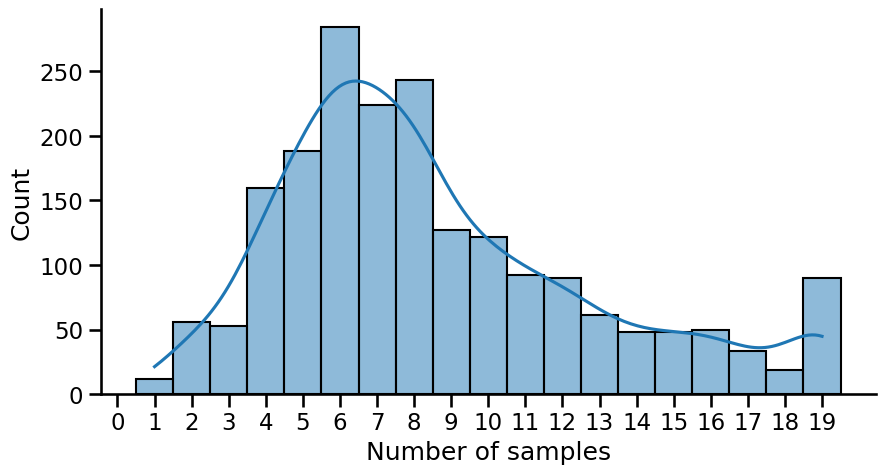

In [14]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(
        data=df_nsamples, x="n_samples", ax=ax, bins=19, discrete=True, kde=True
    )
    ax.set(xticks=np.arange(20), xlabel="Number of samples", ylabel="Count")

    sns.despine(fig)

In [15]:
mean_samples = df_nsamples["n_samples"].mean()
print(
    f"mean {mean_samples:.1f}, SD {df_nsamples['n_samples'].std():.1f}",
)
print(f"median {np.median(df_nsamples['n_samples']):.1f}")
print(f"mode {scipy.stats.mode(df_nsamples['n_samples'])[0][0]:.1f}")

mean 8.6, SD 4.2
median 8.0
mode 6.0


# What were the experienced and true accuracies in the conditions?

- experienced accuracy = accuracy judged according to what was seen
- true accuracy = accuracy judged based on the underlying, true, distributions

NOTE: Need to remove "ambiguous trials", where one of the following conditions was met:

- only one option was sampled
- the expected values for both options were equal

## Calculate accuracies

In [16]:
# Calculate an accuracy dataframe for each accuracy type ... to eventually concatenate them
dfs = list()
for accuracy_type in ["experienced", "true"]:

    tmp_df = df.copy()

    if accuracy_type == "experienced":
        ev_to_base_on0 = "exp_ev0"
        ev_to_base_on1 = "exp_ev1"
    elif accuracy_type == "true":
        ev_to_base_on0 = "true_ev0"
        ev_to_base_on1 = "true_ev1"

    # ambiguous rows, where the experienced EVs are equal
    ev_equal_rows = (tmp_df["exp_ev0"] == tmp_df["exp_ev1"]).to_numpy()
    tmp_df["evs_equal"] = ev_equal_rows

    # ambiguous rows, where only one option was sampled
    # NOTE: this will produce wrong data for DESC task
    # (see https://github.com/sappelhoff/sp_experiment/issues/8)
    only_left_sampled = (
        tmp_df.groupby(["subject", "trial", "task"])["action"].mean() == 0
    )
    only_right_sampled = (
        tmp_df.groupby(["subject", "trial", "task"])["action"].mean() == 1
    )
    single_option_sampled = np.logical_or(only_left_sampled, only_right_sampled)

    # merge the single option rows into tmp_df
    single_option_sampled = single_option_sampled.reset_index()
    single_option_sampled = single_option_sampled.rename(
        {"action": "single_option_sampled"}, axis=1
    )
    tmp_df = pd.merge(
        tmp_df,
        single_option_sampled,
        on=["subject", "trial", "task"],
        validate="many_to_one",
    )

    # NOTE: For description task, trials are never ambiguous for cases were only a single option was sampled
    # because these cases were replaced with descriptions of true underlying distributions
    # rather than descriptions of the experienced distributions
    # Still, we mark them as ambiguous to prevent analyzing data from two different sources (experienced vs true)
    # For each subject, overwrite "single_option_sampled" column for DESC task with the
    # corresponding data from the active task (either AV or AF, depending on subject)
    for subj in range(1, 41):
        idx_active = (tmp_df["subject"] == subj) & (
            ~tmp_df["task"].isin(["DESC", "YV", "YF"])
        )
        idx_desc = (tmp_df["subject"] == subj) & (tmp_df["task"] == "DESC")
        data = (
            tmp_df[idx_active]
            .drop_duplicates(subset="trial")["single_option_sampled"]
            .to_numpy()
        )
        tmp_df.loc[idx_desc, "single_option_sampled"] = data

    # ambiguous rows overall (equal EVs, or single option sampled)
    tmp_df["ambiguous_trial"] = np.logical_or(
        tmp_df["evs_equal"], tmp_df["single_option_sampled"]
    ).to_numpy()

    # Group data by subject, task, and trial ... taking the mean over samples
    # --> the mean should leave "fin_action", "ambiguous_trial" and EVs unchanged, ...
    # because they are the same over samples
    tmp_df = (
        tmp_df.groupby(["subject", "task", "trial"])[
            [ev_to_base_on0, ev_to_base_on1, "ambiguous_trial", "fin_action"]
        ]
        .mean()
        .reset_index()
    )

    # Remove ambiguous trials
    tmp_df = tmp_df[~tmp_df["ambiguous_trial"]]

    # Add column when correct choice was made
    right_better = (tmp_df[ev_to_base_on0] < tmp_df[ev_to_base_on1]).to_numpy()
    right_selected = (tmp_df["fin_action"] == 1).to_numpy()
    tmp_df["correct_choice"] = right_better == right_selected

    # Calculate accuracy as mean correct choices over trials per subject and task
    accuracy_df = (
        tmp_df.groupby(["subject", "task"])["correct_choice"].mean().reset_index()
    )
    accuracy_df["accuracy_type"] = accuracy_type
    dfs.append(accuracy_df)

accuracy_df = pd.concat(dfs, ignore_index=True)
accuracy_df.head()

,subject,task,correct_choice,accuracy_type
0,1,AF,0.927083,experienced
1,1,DESC,0.948980,experienced
2,1,YF,0.916667,experienced
3,2,AV,0.918367,experienced
4,2,DESC,0.948454,experienced


In [17]:
fname_beh_acc = op.join(BIDS_ROOT, "code", "beh_accs.csv")
accuracy_df.to_csv(fname_beh_acc, index=False)

## Sanity check for yoking scheme: Comparing "yoked to self" and "yoked to other"

in "yoked", watching the stream of a different person may be different from watching our own stream

... are the accuracies different between these groups?

In [18]:
# get list of subj ids who were yoked to themselves
yoked_to_self = participants_tsv["participant_id"][
    participants_tsv["participant_id"] == participants_tsv["yoked_to"]
].to_list()
yoked_to_self = [int(i[-2:]) for i in yoked_to_self]

In [19]:
# add a column to accuracy df
accuracy_df["yoked_to"] = "n/a"
accuracy_df.loc[accuracy_df["subject"].isin(yoked_to_self), "yoked_to"] = "self"
accuracy_df.loc[~accuracy_df["subject"].isin(yoked_to_self), "yoked_to"] = "other"

In [20]:
# print out a summary
accuracy_df.groupby(["task", "yoked_to", "accuracy_type"])["correct_choice"].describe()

count      mean       std       min       25%  \
task yoked_to accuracy_type                                                  
AF   other    experienced     10.0  0.778822  0.067724  0.635417  0.750000   
              true            10.0  0.741733  0.083912  0.604167  0.676316   
     self     experienced     10.0  0.812750  0.074279  0.724490  0.768716   
              true            10.0  0.744996  0.061647  0.645833  0.712101   
AV   other    experienced     10.0  0.853865  0.059201  0.762887  0.813158   
              true            10.0  0.758437  0.055913  0.677778  0.723529   
     self     experienced     10.0  0.823021  0.067972  0.673469  0.790946   
              true            10.0  0.735331  0.048926  0.642857  0.715402   
DESC other    experienced     20.0  0.871752  0.067781  0.725000  0.836186   
              true            20.0  0.871752  0.067781  0.725000  0.836186   
     self     experienced     20.0  0.881418  0.052123  0.750000  0.856061   
              true            20.0  0.881418  0.052123  0.750000  0.856061   
YF   other    experienced     10.0  0.817124  0.054972  0.739583  0.796407   
              true            10.0  0.757745  0.055156  0.677083  0.722074   
     self     experienced     10.0  0.789748  0.082924  0.653061  0.728618   
              true            10.0  0.734625  0.066281  0.627660  0.697917   
YV   other    experienced     10.0  0.817131  0.053386  0.734694  0.779656   
              true            10.0  0.721576  0.081630  0.574468  0.654974   
     self     experienced     10.0  0.788210  0.053020  0.683673  0.771628   
              true            10.0  0.716532  0.058422  0.606383  0.680889   

                                  50%       75%       max  
task yoked_to accuracy_type                                
AF   other    experienced    0.773065  0.835822  0.860215  
              true           0.746130  0.799769  0.881720  
     self     experienced    0.784242  0.857214  0.928571  
              true           0.737032  0.780935  0.846939  
AV   other    experienced    0.866644  0.901030  0.919540  
              true           0.747542  0.798402  0.858696  
     self     experienced    0.849393  0.856775  0.918367  
              true           0.723983  0.778515  0.795918  
DESC other    experienced    0.892857  0.924451  0.949495  
              true           0.892857  0.924451  0.949495  
     self     experienced    0.884087  0.919394  0.948980  
              true           0.884087  0.919394  0.948980  
YF   other    experienced    0.802083  0.856399  0.915789  
              true           0.757759  0.792282  0.842105  
     self     experienced    0.807534  0.822917  0.916667  
              true           0.756498  0.774341  0.833333  
YV   other    experienced    0.813588  0.854197  0.901099  
              true           0.755236  0.777473  0.795918  
     self     experienced    0.808655  0.823980  0.846154  
              true           0.714110  0.751275  0.802198

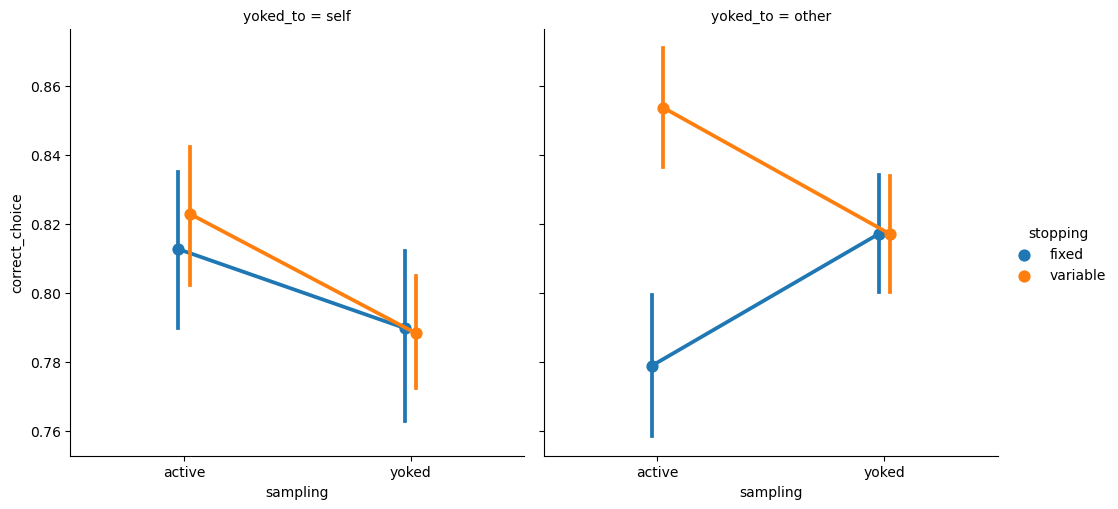

In [21]:
# visualize as 2x2x2 catplot
tmp = accuracy_df[
    (accuracy_df["task"] != "DESC") & (accuracy_df["accuracy_type"] == "experienced")
]

tmp.insert(
    2, "sampling", ["active" if i == "A" else "yoked" for i in tmp["task"].str[0]]
)
tmp.insert(
    3, "stopping", ["fixed" if i == "F" else "variable" for i in tmp["task"].str[1]]
)

grid = sns.catplot(
    kind="point",
    ci=68,
    dodge=True,
    x="sampling",
    y="correct_choice",
    hue="stopping",
    data=tmp,
    col="yoked_to",
)


In [22]:
tmp.groupby("yoked_to")["correct_choice"].describe()

,count,mean,std,min,25%,50%,75%,max
yoked_to,,,,,,,,
other,40.0,0.816736,0.062805,0.635417,0.764701,0.813588,0.857911,0.919540
self,40.0,0.803432,0.069305,0.653061,0.769691,0.808655,0.847773,0.928571


In [23]:
xname = "self"
yname = "other"
x = tmp[tmp["yoked_to"] == xname]["correct_choice"].to_numpy()
y = tmp[tmp["yoked_to"] == yname]["correct_choice"].to_numpy()
model = pingouin.ttest(x, y, paired=False)

print(
    f"ttest\nMean accuracies\n{xname}: {np.round(x.mean(), 2)}, {yname}: {np.round(y.mean(),2)}"
)
print(
    f"t({model['dof'][0]})={np.round(model['T'][0], 3)}, p={np.round(model['p-val'][0], 3)}"
)
display(model)

ttest
Mean accuracies
self: 0.8, other: 0.82
t(78)=-0.9, p=0.371


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.899595,78,two-sided,0.371105,"[-0.04, 0.02]",0.201156,0.33,0.144189


### Use rpy2 for mixed anova

see: https://www.marsja.se/r-from-python-rpy2-tutorial/

In [ ]:
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

In [26]:
# convert pandas DF to R data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(tmp)
    
r_from_pd_df.head()

subject,task,sampling,stopping,correct_choice,accuracy_type,yoked_to
...,...,...,...,...,...,...


In [27]:
afex = rpackages.importr("afex")

In [28]:
## see: https://cran.r-project.org/web/packages/afex/afex.pdf
model = afex.aov_ez(
    id="subject",
    dv="correct_choice",
    between=["stopping", "yoked_to"],
    within="sampling",
    data=r_from_pd_df,
    check_contrasts=True,  # 3-way interaction is unaffected by this, "True" is recommended
    type=3,  # using so-called type 3 sums of squares
    print_formula=True,
)

print(model)

R[write to console]: Formula send to aov_car: correct_choice ~ stopping * yoked_to + Error(subject/(sampling))

R[write to console]: Converting to factor: stopping, yoked_to

R[write to console]: Contrasts set to contr.sum for the following variables: stopping, yoked_to



Anova Table (Type 3 tests)

Response: correct_choice
                      Effect    df  MSE      F  ges p.value
1                   stopping 1, 36 0,01   1,30 ,028    ,262
2                   yoked_to 1, 36 0,01   0,52 ,012    ,474
3          stopping:yoked_to 1, 36 0,01   0,81 ,018    ,373
4                   sampling 1, 36 0,00   2,34 ,013    ,134
5          stopping:sampling 1, 36 0,00 5,59 * ,030    ,024
6          yoked_to:sampling 1, 36 0,00   2,61 ,014    ,115
7 stopping:yoked_to:sampling 1, 36 0,00 2,96 + ,016    ,094
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘+’ 0,1 ‘ ’ 1



## Overview plot

In [29]:
# add sampling and stopping cols to DF
sampstop_data = np.array([[i[0], i[1]] for i in accuracy_df["task"].to_list()])
sampstop_data[(sampstop_data == "D") | (sampstop_data == "E")] = ""
accuracy_df["sampling"] = sampstop_data[:, 0]
accuracy_df["stopping"] = sampstop_data[:, 1]

In [30]:
# save data for publication plots
plotdir = op.join(BIDS_ROOT, "code", "publication_plots")
os.makedirs(plotdir, exist_ok=True)

fname = "beh_accuracies.csv"
fname = op.join(plotdir, fname)

tmp = accuracy_df[accuracy_df["accuracy_type"] == "experienced"]
tmp = tmp[tmp["task"] != "DESC"]
tmp["sampling"] = tmp["sampling"].map({"A": "Active", "Y": "Yoked"})
tmp["stopping"] = tmp["stopping"].map({"V": "Variable", "F": "Fixed"})

tmp.to_csv(fname, index=False)

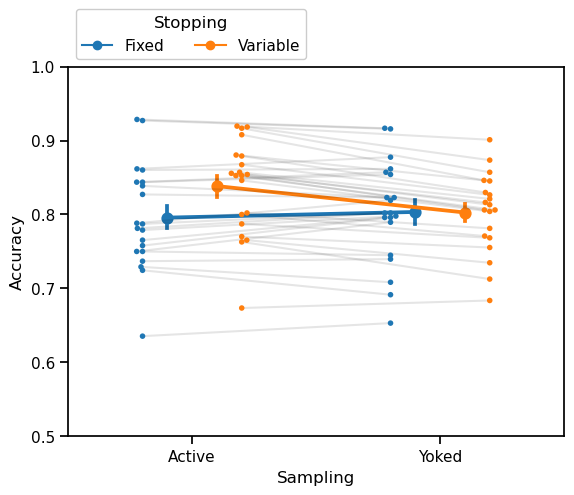

In [31]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots()

    sns.pointplot(
        x="sampling",
        y="correct_choice",
        hue="stopping",
        data=tmp,
        ci=68,
        dodge=0.2,
        hue_order=["Fixed", "Variable"],
        ax=ax,
        markers="o",
    )

    sns.swarmplot(
        x="sampling",
        y="correct_choice",
        hue="stopping",
        data=tmp,
        hue_order=["Fixed", "Variable"],
        ax=ax,
        dodge=True,
        size=4,
    )

    # add legend
    # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D([0], [0], color=sns.color_palette()[0], marker="o", label="Fixed"),
        Line2D([0], [0], color=sns.color_palette()[1], marker="o", label="Variable"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="lower left",
        framealpha=1,
        bbox_to_anchor=(0, 1),
        ncol=2,
        title="Stopping",
    )

    ax.set_ylim((0.5, 1.0))
    ax.set_ylabel("accuracy")

    # https://stackoverflow.com/a/51157346/5201771
    # 2-4 3-5
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, color="black", alpha=0.1)

    # ax.set_yticks(np.arange(0.6, 0.95, 0.02))
    # ax.grid('on')
    ax.set_xlabel("Sampling")
    ax.set_ylabel("Accuracy")


## statistical testing

In [32]:
# Summary statistics
accuracy_df.groupby(["task", "accuracy_type"])["correct_choice"].describe()

count      mean       std       min       25%       50%  \
task accuracy_type                                                            
AF   experienced     20.0  0.795786  0.071337  0.635417  0.750000  0.784242   
     true            20.0  0.743364  0.071682  0.604167  0.699866  0.737032   
AV   experienced     20.0  0.838443  0.064024  0.673469  0.796809  0.853399   
     true            20.0  0.746884  0.052490  0.642857  0.717634  0.733004   
DESC experienced     40.0  0.876585  0.059881  0.725000  0.847704  0.891794   
     true            40.0  0.876585  0.059881  0.725000  0.847704  0.891794   
YF   experienced     20.0  0.803436  0.069899  0.653061  0.778330  0.802083   
     true            20.0  0.746185  0.060520  0.627660  0.706449  0.756498   
YV   experienced     20.0  0.802670  0.053868  0.683673  0.770230  0.809655   
     true            20.0  0.719054  0.069136  0.574468  0.676180  0.746133   

                         75%       max  
task accuracy_type                      
AF   experienced    0.843750  0.928571  
     true           0.794367  0.881720  
AV   experienced    0.879449  0.919540  
     true           0.787088  0.858696  
DESC experienced    0.920769  0.949495  
     true           0.920769  0.949495  
YF   experienced    0.854911  0.916667  
     true           0.775782  0.842105  
YV   experienced    0.833681  0.901099  
     true           0.771978  0.802198

In [33]:
# Mean +- SEM for specific selection


def sns_ci(a):
    """Helper to get seaborn 68% ci (~SEM)."""
    it = sns.utils.ci(sns.algorithms.bootstrap(a), 68)
    return np.mean([np.abs(a.mean() - it[0]), np.abs(a.mean() - it[1])])


accuracy_df[
    (accuracy_df["accuracy_type"] == "experienced") & (accuracy_df["task"] != "DESC")
].groupby(["task", "accuracy_type"]).agg(
    {"correct_choice": [np.mean, scipy.stats.sem, sns_ci]}
).round(
    3
).reset_index()

task accuracy_type correct_choice              
                               mean    sem sns_ci
0   AF   experienced          0.796  0.016  0.015
1   AV   experienced          0.838  0.014  0.014
2   YF   experienced          0.803  0.016  0.015
3   YV   experienced          0.803  0.012  0.012

### mixed anova

In [34]:
accuracy_type = "experienced"

tt = accuracy_df.loc[
    (accuracy_df["task"] != "DESC")
    & (accuracy_df["accuracy_type"] == accuracy_type),
    :,
]

# calculate model
model = pingouin.mixed_anova(
    data=tt,
    dv="correct_choice",
    within="sampling",
    between="stopping",
    subject="subject",
).round(3)

display(model)

# calculate posthocs

stats = pingouin.pairwise_ttests(
    data=tt,
    padjust="bonf",
    dv="correct_choice",
    within="sampling",
    between="stopping",
    subject="subject",
    within_first=False,
    effsize="cohen",
).round(3)

display(stats)



,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,stopping,0.009,1,38,0.009,1.321,0.258,0.034,NaN
1,sampling,0.004,1,38,0.004,2.143,0.151,0.053,1.0
2,Interaction,0.009,1,38,0.009,5.108,0.030,0.118,NaN


,Contrast,stopping,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,stopping,-,F,V,False,True,-1.149,38.0,two-sided,0.258,NaN,NaN,0.521,-0.363
1,sampling,-,A,Y,True,True,1.392,39.0,two-sided,0.172,NaN,NaN,0.416,0.213
2,stopping * sampling,F,A,Y,True,True,-0.561,19.0,two-sided,0.582,1.000,bonf,0.268,-0.108
3,stopping * sampling,V,A,Y,True,True,2.644,19.0,two-sided,0.016,0.032,bonf,3.473,0.605


## single subj scatterplot

with **active** task on x-axis and **yoked** task on y-axis

In [35]:
# Collapse df to wide format
dd = pd.pivot_table(
    accuracy_df,
    index=["subject", "accuracy_type"],
    values="correct_choice",
    columns="task",
)
dd = dd.reset_index()


In [36]:
def _label_point(x, y, val, ax):
    """Label points in a plot: https://stackoverflow.com/a/46028674/5201771."""
    a = pd.concat({"x": x, "y": y, "val": val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point["x"], point["y"], str(int(point["val"])), fontsize=10)

In [37]:
# idxs for FIXED vs VARIABLE tasks
variable_idx = dd["subject"].isin(range(2, 41, 2)).to_numpy()
fixed_idx = dd["subject"].isin(range(1, 41, 2)).to_numpy()

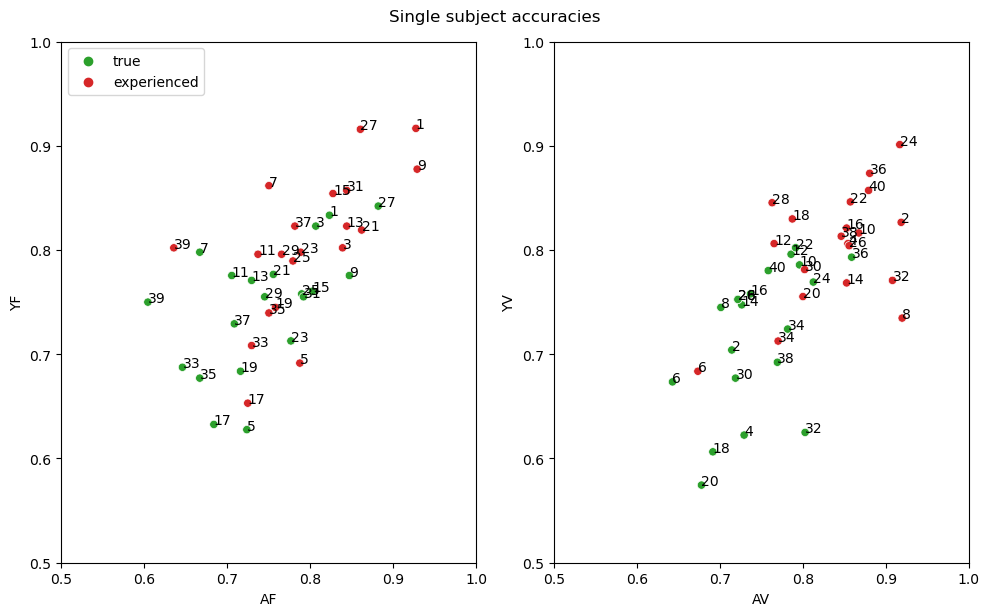

In [38]:
# Plot single subject accuracies
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=False)

for ax, taskset, xyidx in zip(
    axs, [["AF", "YF"], ["AV", "YV"]], [fixed_idx, variable_idx]
):
    x, y = taskset
    legend = "brief" if x == "AF" else False
    sns.scatterplot(
        x=x,
        y=y,
        hue="accuracy_type",
        data=dd,
        ax=ax,
        legend=legend,
        palette=sns.color_palette()[2:4],
        markers=".",
        hue_order=["true", "experienced"],
    )

    _label_point(dd.loc[xyidx, x], dd.loc[xyidx, y], dd.loc[xyidx, "subject"], ax)

    if legend:
        ax.legend(loc=2)


axs.flat[0].set_xlim((0.5, 1))
axs.flat[0].set_ylim((0.5, 1))
axs.flat[1].set_ylim((0.5, 1))


fig.tight_layout()
plt.suptitle("Single subject accuracies", y=1.02)



# Is "numeracy" correlated with n_samples or accuracy?

- According to Peters2012 --> more numeracy, more n_samples

scoring according to:
- Cokely, E. T., Galesic, M., Schulz, E., Ghazal, S., & Garcia-Retamero, R. (2012). Measuring Risk Literacy: The Berlin Numeracy Test. Judgment and Decision Making. https://doi.org/10.1037/t45862-000

Dividing sample into 4 quartiles through "adaptive scoring":

- quartile 1 --> got 1 wrong, 2a wrong 
- quartile 2 --> got 1 wrong, 2a right
- quartile 3 --> got 1 right, 2b wrong, 3 wrong
- quartile 4 --> got 1 right, 2b right ... OR 2b wrong, but 3 right

The 4th quartile has the highest numeracy skill


The adaptive scoring questions 1, 2a, 2b, and 3 correspond to q1, q4, q2, q3 in our data.


In [39]:
df_bnt = get_df_bnt(BIDS_ROOT)

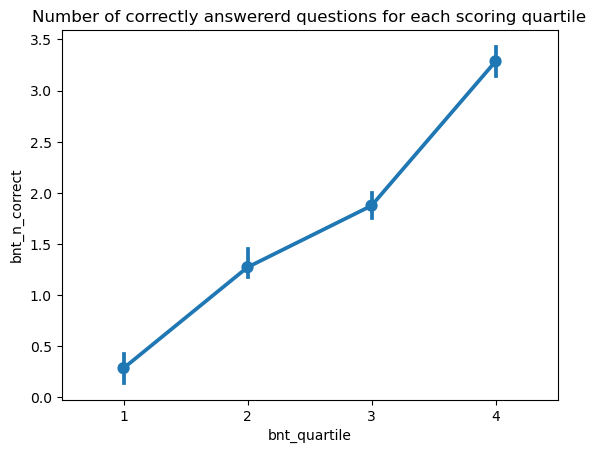

In [40]:
# sanity check: high quartiles should also have an overall higher number
# of correctly answered questions
fig, ax = plt.subplots()
sns.pointplot(x="bnt_quartile", y="bnt_n_correct", data=df_bnt, ci=68, ax=ax)
ax.set_title("Number of correctly answererd questions " "for each scoring quartile")


In [41]:
# Sanity check 2: quartiles 1+2 should be around 50% of all cases if this
# sample is comparable to the sample the original BNT study was based on
np.sum(df_bnt["bnt_quartile"] <= 2) / len(df_bnt)

0.45

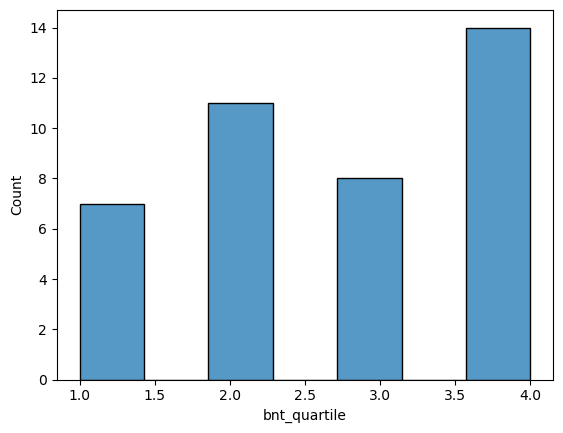

In [42]:
fig, ax = plt.subplots()
sns.histplot(x="bnt_quartile", data=df_bnt, ax=ax)


## numeracy and n_samples

In [43]:
tmp = df_nsamples.groupby("subject").mean().reset_index()
tmp = tmp.merge(df_bnt[["subject", "bnt_quartile"]], on="subject")
tmp = df_nsamples.merge(df_bnt[["subject", "bnt_quartile"]], on="subject")
tmp.head()

,subject,task,trial,n_samples,bnt_quartile
0,2,AV,0,15,2
1,2,AV,1,7,2
2,2,AV,2,3,2
3,2,AV,3,4,2
4,2,AV,4,6,2


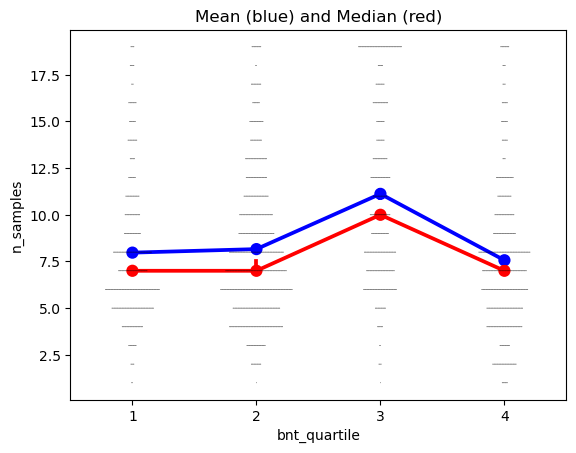

In [44]:
fig, ax = plt.subplots()
sns.pointplot(
    x="bnt_quartile",
    y="n_samples",
    data=tmp,
    ci=68,
    ax=ax,
    estimator=np.mean,
    color="blue",
)
sns.pointplot(
    x="bnt_quartile",
    y="n_samples",
    data=tmp,
    ci=68,
    ax=ax,
    estimator=np.median,
    color="red",
)
sns.swarmplot(x="bnt_quartile", y="n_samples", data=tmp, ax=ax, size=0.5, color="black")
ax.set_title("Mean (blue) and Median (red)")


## numeracy and accuracy

In [45]:
tmp = accuracy_df.merge(df_bnt[["subject", "bnt_quartile"]], on="subject")
tmp = tmp[tmp["task"] != "DESC"]

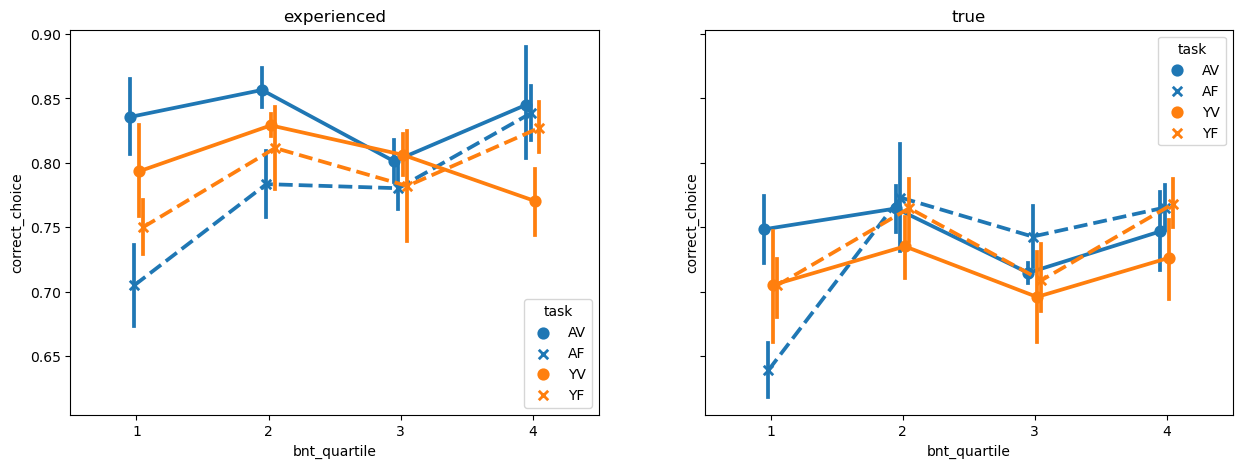

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for ax, acctype in zip([ax1, ax2], ["experienced", "true"]):

    sns.pointplot(
        x="bnt_quartile",
        y="correct_choice",
        data=tmp[tmp["accuracy_type"] == acctype],
        ci=68,
        dodge=True,
        hue="task",
        hue_order=["AV", "AF", "YV", "YF"],
        markers=["o", "x", "o", "x"],
        linestyles=["-", "--", "-", "--"],
        palette=[
            sns.color_palette()[0],
            sns.color_palette()[0],
            sns.color_palette()[1],
            sns.color_palette()[1],
        ],
        ax=ax,
    )
    ax.set_title(acctype)



In [47]:
# Correlate accuracy (averaged over active/yoked per subj) and BNT
bnt_acc_corr_df = (
    tmp.groupby("subject")[["correct_choice", "bnt_quartile"]].mean().reset_index()
)

pingouin.correlation.corr(
    bnt_acc_corr_df["correct_choice"],
    bnt_acc_corr_df["bnt_quartile"],
    tail="one-sided",
    method="kendall",
).round(3)

,n,r,CI95%,p-val,power
kendall,40,0.194,"[-0.13, 0.48]",0.056,0.332


### Use rpy2 for mixed anova

see: https://www.marsja.se/r-from-python-rpy2-tutorial/

In [50]:
tmp = accuracy_df.merge(df_bnt[["subject", "bnt_quartile"]], on="subject")
tmp = tmp[tmp["task"] != "DESC"]

acctype = "experienced"
tmp = tmp[tmp["accuracy_type"] == acctype]

tmp.head()

,subject,task,correct_choice,accuracy_type,yoked_to,sampling,stopping,bnt_quartile
0,1,AF,0.927083,experienced,self,A,F,4
2,1,YF,0.916667,experienced,self,Y,F,4
6,2,AV,0.918367,experienced,self,A,V,2
8,2,YV,0.826531,experienced,self,Y,V,2
12,3,AF,0.838710,experienced,other,A,F,4


In [51]:
for col in ["stopping", "sampling", "task", "accuracy_type"]:
    tmp[col] = tmp[col].astype("category")

In [52]:
# convert pandas DF to R data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(tmp)

In [53]:
r_from_pd_df.head()

subject,task,correct_choice,...,sampling,stopping,bnt_quartile
1,AF,0.927083,...,A,F,4
1,YF,0.916667,,Y,F,4
2,AV,0.918367,,A,V,2
2,YV,0.826531,,Y,V,2
3,AF,0.838710,,A,F,4
3,YF,0.802083,,Y,F,4


In [54]:
afex = rpackages.importr("afex")

In [55]:
model = afex.aov_ez(
    id="subject",
    dv="correct_choice",
    between=["stopping", "bnt_quartile"],
    within="sampling",
    data=r_from_pd_df,
)
print("acc type: {}".format(acctype))
print(model)

R[write to console]: Converting to factor: bnt_quartile

R[write to console]: Contrasts set to contr.sum for the following variables: stopping, bnt_quartile



acc type: experienced
Anova Table (Type 3 tests)

Response: correct_choice
                          Effect    df  MSE      F  ges p.value
1                       stopping 1, 32 0,01 3,22 + ,071    ,082
2                   bnt_quartile 3, 32 0,01   1,66 ,106    ,196
3          stopping:bnt_quartile 3, 32 0,01   1,79 ,114    ,169
4                       sampling 1, 32 0,00   0,89 ,007    ,353
5              stopping:sampling 1, 32 0,00 6,36 * ,045    ,017
6          bnt_quartile:sampling 3, 32 0,00   1,55 ,033    ,220
7 stopping:bnt_quartile:sampling 3, 32 0,00   0,80 ,017    ,503
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘+’ 0,1 ‘ ’ 1



# find stereotypic sampling pattern

- for example, "piecewise": `a b a b a b` --> if sequence_length - 1 switches in sequence and sequence length > 4
- or, "comprehensive": `a a a a b b b b` --> if single switch in sequence and sequence length > 1


In [56]:
# Calculate switches using "action" and "trial" column
# A switch happens when *within* a trial, the participant
# changes from sampling one option to the other option
# The first sample at the "other option" is considered the
# switch trial.
dat = zip(df["action"].to_numpy(), df["trial"].to_numpy())

# initialize a "previous trial" variable for preventing
# counting switches across trial boundaries
prev_trial = -9999999

# Collect booleans for each trial whether it was a switch
switches = list()
for act, trial in dat:
    # if we go on to a new trial in the data, an action is
    # never counted as a switch
    if trial != prev_trial:
        prev_act = act
        prev_trial = trial
    # Else, an action is a switch if the action is different
    # from the action before
    switches.append(act != prev_act)
    prev_act = act

df["switch"] = switches

In [57]:
_df = df[df["task"].isin(["AF", "AV"])][
    ["subject", "task", "trial", "sample", "action", "switch"]
]

In [58]:
# classify each trial into "0=comprehensive" (aaabbb), "1=piecewise"(ababab), ...
# "np.nan=invalid"(seq length <4, or only one option), or "2=other"
#
# The <4 requirement is important to distinguish "ab" trials: these are
# ambiguous: comprehensive or piecewise.
#
# when strict=True, the mean of actions must be 0.5, so only aabb, aaabbb, ...
# and abab, ababab, ... are valid

comprehensive_tolerance = 2
strict = False

classification = dict(subject=[], task=[], trial=[], classification=[])
for meta, grp in _df.groupby(["subject", "task", "trial"]):
    n_switches = grp["switch"].sum()
    n_samples = len(grp)

    # too short sequences are invalid
    if (len(grp["action"].unique()) != 2) or (n_samples < 4):
        classi = np.nan

    # exactly one switch means "comprehensive"
    elif (n_samples > 1) and n_switches == 1:
        classi = 0

        # Check within tolerance for equal samples from each option
        # to exclude patterns like aaaaaaaab
        diff_0_1 = np.abs(np.diff(grp["action"].value_counts().to_numpy()))
        if diff_0_1 > comprehensive_tolerance:
            classi = 2

        # In the strict case, left and right must be samples evenly
        if strict and not np.allclose(grp["action"].mean(), 0.5):
            classi = 2

    # switching each times meas "piecewise"
    elif (n_samples >= 2) and n_switches == (n_samples - 1):
        classi = 1

        # In the strict case, left and right must be samples evenly
        if strict and not np.allclose(grp["action"].mean(), 0.5):
            classi = 2

    # all other are "other" (mixed)
    else:
        classi = 2

    subj, task, trl = meta
    classification["subject"] += [subj]
    classification["task"] += [task]
    classification["trial"] += [trl]
    classification["classification"] += [classi]

# make DF
classification_df = pd.DataFrame(classification)
assert len(classification_df) == 4000

In [59]:
n_na = len(classification_df) - len(classification_df.dropna())
print(f"Need to drop {n_na} trials for different reasons:")
print(
    "\nonly one option chosen, or only one sample taken"
    "\n(strictly speaking the latter reason is the same as the former)"
)

classification_df_na = classification_df.copy()
classification_df = classification_df.dropna()

Need to drop 184 trials for different reasons:

only one option chosen, or only one sample taken
(strictly speaking the latter reason is the same as the former)


In [60]:
# Summarize the proportion of used strategies per subject
data = {"subject": [], "task": [], "comprehensive": [], "piecewise": [], "other": []}
for meta, grp in classification_df.groupby(["subject", "task"]):
    subj, task = meta

    for i, style in enumerate(["comprehensive", "piecewise", "other"]):
        try:
            a = (grp["classification"].value_counts() / len(grp))[i]
        except KeyError:
            a = 0.0

        data[style] += [a]

    data["subject"] += [subj]
    data["task"] += [task]


class_summary_df = pd.DataFrame(data)

# stereotypic sampling is either comprehensive or piecewise
class_summary_df["stereotypic"] = (
    class_summary_df["comprehensive"] + class_summary_df["piecewise"]
)

/home/stefanappelhoff/miniconda3/envs/sp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stefanappelhoff/miniconda3/envs/sp/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefanappelhoff/miniconda3/envs/sp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stefanappelhoff/miniconda3/envs/sp/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stefanappelhoff/miniconda3/envs/sp/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stefanappelhoff/miniconda3/envs/sp/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encounte

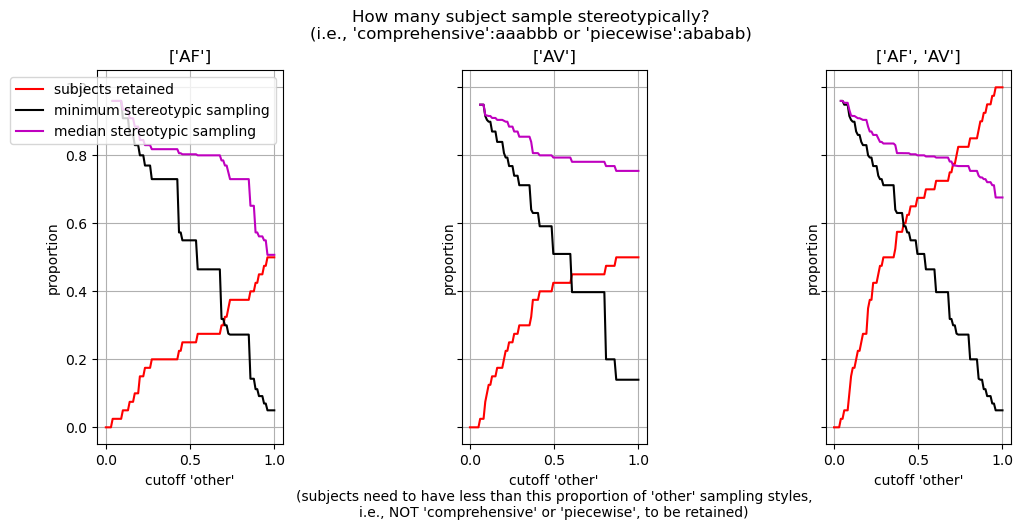

In [61]:
summary_stat_to_use = np.median  # np.median or np.mean

# NOTE: np.median might give warnings for the cases where all subjs are excluded

# plot tradeoff: What % of subj did use stereotypic sampling on **at least** % or trials?
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
n = 100
cutoffs = np.linspace(1, 0, n)
nsubjs_norm = np.interp(np.arange(0, 41), (0, 40), (0, 1))

for ipartition, partition in enumerate([["AF"], ["AV"], ["AF", "AV"]]):

    _df_to_work_on = class_summary_df[class_summary_df["task"].isin(partition)]
    ax = axs.flat[ipartition]

    plot_data = np.full((3, n), np.nan)
    for i, cutoff in enumerate(cutoffs):

        nsubjs_in_data = len(_df_to_work_on[_df_to_work_on["other"] < cutoff])
        min_stereo = _df_to_work_on[_df_to_work_on["other"] < cutoff][
            "stereotypic"
        ].min()

        summary_stereo = summary_stat_to_use(
            _df_to_work_on[_df_to_work_on["other"] < cutoff]["stereotypic"]
        )

        plot_data[0, i] = nsubjs_in_data
        plot_data[1, i] = min_stereo
        plot_data[2, i] = summary_stereo

    # plot
    ax.plot(
        cutoffs,
        nsubjs_norm[plot_data[0, :].astype(int)],
        color="r",
        label="subjects retained",
    )
    ax.plot(cutoffs, plot_data[1, :], color="k", label="minimum stereotypic sampling")
    ax.plot(
        cutoffs,
        plot_data[2, :],
        color="m",
        label=f"{summary_stat_to_use.__name__} stereotypic sampling",
    )

    xlab = "cutoff 'other'"
    if ipartition == 1:
        xlab += "\n(subjects need to have less than this proportion of 'other' sampling styles,"
        xlab += "\ni.e., NOT 'comprehensive' or 'piecewise', to be retained)"
    ax.set(xlabel=xlab, ylabel="proportion", title=partition)
    ax.grid("on")

    if ipartition == 0:
        leg = ax.legend()


fig.suptitle(
    "How many subject sample stereotypically?\n(i.e., 'comprehensive':aaabbb or 'piecewise':ababab)",
    y=1.05,
)
fig.tight_layout()


In [62]:
cutoffs = [0.3, 0.3, 0.4]

for ipartition, partition in enumerate([["AF"], ["AV"], ["AF", "AV"]]):

    _df_to_work_on = class_summary_df[class_summary_df["task"].isin(partition)]
    cutoff = cutoffs[ipartition]

    nsubjs_in_data = len(_df_to_work_on[_df_to_work_on["other"] < cutoff])
    min_stereo = _df_to_work_on[_df_to_work_on["other"] < cutoff]["stereotypic"].min()
    summary_stereo = summary_stat_to_use(
        _df_to_work_on[_df_to_work_on["other"] < cutoff]["stereotypic"]
    )

    print(f"\n\n{partition}")
    print(
        f"{nsubjs_in_data} subjects sampled at least {min_stereo*100:.2f}% of trials in stereotypic form."
    )
    print(
        f"{nsubjs_in_data} subjects sampled {summary_stereo*100:.2f}% of trials in stereotypic form on average ({summary_stat_to_use.__name__})."
    )



['AF']
8 subjects sampled at least 73.00% of trials in stereotypic form.
8 subjects sampled 81.81% of trials in stereotypic form on average (median).


['AV']
12 subjects sampled at least 71.21% of trials in stereotypic form.
12 subjects sampled 85.48% of trials in stereotypic form on average (median).


['AF', 'AV']
23 subjects sampled at least 63.04% of trials in stereotypic form.
23 subjects sampled 80.65% of trials in stereotypic form on average (median).


In [63]:
all_av_stereo = summary_stat_to_use(
    (class_summary_df[class_summary_df["task"] == "AV"]["stereotypic"]) * 100
).round(2)

all_af_stereo = summary_stat_to_use(
    (class_summary_df[class_summary_df["task"] == "AF"]["stereotypic"]) * 100
).round(2)

all_stereo = summary_stat_to_use((class_summary_df["stereotypic"]) * 100).round(2)

print(
    f"Over all subjects,\n{all_av_stereo}% in AV,\n{all_af_stereo}% in AF,\n{all_stereo}% overall,"
    f"\nsampled in stereotypic form ..."
)

Over all subjects,
75.42% in AV,
50.73% in AF,
67.61% overall,
sampled in stereotypic form ...


# Decision weights via logisitic regression

Two vectors are needed:
- `X`: the sample outcomes from both options (one option "flipped" such that 1=9, 2=8, ..., 9=1)
    - this "flip" is equivalent to first mean-centering the vector of outcomes, and then flipping the signs
    - e.g., 1, 2, 3, 4, 5, 6, 7, 8, 9 --> (mean-center) --> -4, -3, -2, -1, 0, 1, 2, 3, 4 --> (flip)  --> 4, 3, 2, 1, 0, -1, -2, -3, -4
- `y`: the final choices for options (left: 0, right: 1)

Obviously, `y` will have fewer entries than `X`. 
We need to repeat the `y` value of each trial for each sample in that trial.
Finally, we do this for early, mid, and late samples separately


In [64]:
def classify_timing(df, first_last_n):
    """Add a new column 'timing' to the `df` for early/mid/late samples.

    Parameters
    ----------
    df : pandas.DataFrame
        The behavioral data containing `n_samples` and `sample` column.
    first_last_n : int
        Controls the N *first* samples in a sequence and N *last* samples in a
        sequence to be classified into "early" and "late" respectively. The
        samples in between are *mid* samples..
        Sequences that are 2*first_last_n samples long or shorter have
        *mixed* timing and can later be dropped from analysis.

    Returns
    -------
    df : pandas.DataFrame
        A copy of the data with a new column "timing".

    Notes
    -----
    `first_last_n` should be picked low enough such that not too many trials
    will end up with each sample classified as "mixed". At the same time,
    `first_last_n` should be high enough to make the number of "early", "mid",
    and "late" samples per trial as balanced as possible.

    """
    df = df.copy()
    df["timing"] = np.nan

    # NOTE: nth "sample" is 0-indexed ... n_samples is a count
    # "how many steps is *this* sample away from the sequence end?" ...
    # `1` is the end, due to zero-indexing
    sample_diff = (df["n_samples"] - df["sample"]).to_numpy()

    # "how large does the `sample_diff` have to be so that the sample can be classified
    # as early?"
    early_thresh = ((df["n_samples"] + 1) - first_last_n).to_numpy()

    # If there are `first_last_n` or less steps until the sequence end, we have
    # a late sample
    df.loc[sample_diff <= first_last_n, "timing"] = "late"

    # If there are many steps left, we have an early sample
    df.loc[sample_diff >= early_thresh, "timing"] = "early"

    # The remaining rows are "mid" samples ...
    df.loc[df["timing"].isna(), "timing"] = "mid"

    # ... EXCEPT those rows that are of sampling sequences that are too short
    # to be divided into early, mid, and late
    df.loc[(df["n_samples"] <= first_last_n * 2), "timing"] = "mixed"

    return df

In [65]:
def get_log_reg_coef(df, subject, flip, selection):
    """Predict final choice by outcome history.

    Using a logistic regression.

    Parameters
    ----------
    df : pandas.DataFrame
        The data, with columns [subject, sampling, stopping, trial, sample,
        timing, action, outcome, fin_action], and no "DESC" task.
    subject : int
        The subject id.
    flip : 0 | 1
        The "side" to flip (0=left 1=right). Relates to whether an outcome
        was sampled left or right. For the sake of the logistic regression,
        we will "flip" the outcomes on one side such that 1 becomes 9, 2
        becomes 8, ... and 9 becomes 1.
    selection : all | timing | task | timing_task
        On which part(s) of the data to calculate the logistic regression.
        "all" will calculate over all data. "timing" will calculate three
        separate logistic regressions (one for early, mid, and late each).
        "task" will calculate two separate regressions (one for active,
        one for yoked). Finally, "timing_task" will calculate six separate
        regressions: early, mid, late each for active, and yoked.

    Notes
    -----
    If you need a stopping" factor next to "sampling" and are wondering why
    this is not supplied with the `selection` parameter, remember that
    "stopping" was a between factor, so this is implicit. For example, the
    data from sub-01 is always "fixed", sub-02 always "variable", and so on.
    You can use df[["subject", "task"]] to see the mapping.

    Returns
    -------
    coef : dict
        The coefficient(s)

    """
    # work on one subj
    subj_df = df[df["subject"] == subject]
    subj_df = subj_df.reset_index(drop=True)

    outcome = subj_df["outcome"].to_numpy()
    flip_idxs = (subj_df["action"] == flip).to_numpy()

    # "10 - outcome" flips outcome so that 1=9, 2=8, ... 9=1
    outcome_flipped = 10 - outcome[flip_idxs]

    # Add column to df
    subj_df.insert(len(subj_df.columns), "outcome_flipped", outcome)
    subj_df.loc[flip_idxs, "outcome_flipped"] = outcome_flipped

    # sanity check non-flipped outcomes equal
    test = subj_df[subj_df["action"] != flip][["outcome", "outcome_flipped"]].to_numpy()
    np.testing.assert_array_equal(test[:, 0], test[:, 1])

    # sanity check flipped outcomes + original outcomes == 10
    test = subj_df[subj_df["action"] == flip][["outcome", "outcome_flipped"]].to_numpy()
    np.testing.assert_allclose(test[:, 0] + test[:, 1], 10)

    if selection == "all":
        sel = {"all": np.arange(0, subj_df.shape[0])}
    elif selection == "timing":
        sel = {
            "early": subj_df["timing"] == "early",
            "mid": subj_df["timing"] == "mid",
            "late": subj_df["timing"] == "late",
        }
    elif selection == "task":
        sel = {
            "active": subj_df["sampling"] == "active",
            "yoked": subj_df["sampling"] == "yoked",
        }
    elif selection == "timing_task":
        sel = {
            "active/early": (subj_df["sampling"] == "active")
            & (subj_df["timing"] == "early"),
            "active/mid": (subj_df["sampling"] == "active")
            & (subj_df["timing"] == "mid"),
            "active/late": (subj_df["sampling"] == "active")
            & (subj_df["timing"] == "late"),
            "yoked/early": (subj_df["sampling"] == "yoked")
            & (subj_df["timing"] == "early"),
            "yoked/mid": (subj_df["sampling"] == "yoked")
            & (subj_df["timing"] == "mid"),
            "yoked/late": (subj_df["sampling"] == "yoked")
            & (subj_df["timing"] == "late"),
        }
    else:
        raise ValueError(f"What is {selection}?")

    coef = {}
    for selkey, selval in sel.items():
        # IV and DV for linear regression
        X = subj_df.loc[selval, "outcome_flipped"].to_numpy()
        X = np.atleast_2d(X).T
        y = subj_df.loc[selval, "fin_action"].to_numpy()

        # first output is the coef ot the intercept
        _, this_coef = pingouin.logistic_regression(
            X, y, coef_only=True, random_state=42
        )

        # "save"
        coef[selkey] = this_coef

    return coef

In [66]:
# prep df
first_last_n = 2
tmp_logreg = classify_timing(df, first_last_n=first_last_n)


tmp_logreg = tmp_logreg[tmp_logreg["task"] != "DESC"]

tmp_logreg.loc[:, "sampling"] = np.array(["yoked", "active"])[
    tmp_logreg["task"].str.startswith("A").to_numpy(dtype=int)
]
tmp_logreg.loc[:, "stopping"] = np.array(["variable", "fixed"])[
    tmp_logreg["task"].str.endswith("F").to_numpy(dtype=int)
]

cols = [
    "subject",
    "sampling",
    "stopping",
    "trial",
    "sample",
    "timing",
    "action",
    "outcome",
    "fin_action",
]

tmp_logreg = tmp_logreg[cols]
tmp_logreg.head()

,subject,sampling,stopping,trial,sample,timing,action,outcome,fin_action
0,1,active,fixed,0,0,early,1,7,1
1,1,active,fixed,0,1,early,1,4,1
2,1,active,fixed,0,2,mid,1,7,1
3,1,active,fixed,0,3,mid,1,4,1
4,1,active,fixed,0,4,mid,1,4,1


## early mid late ... WITH sampling/stopping division


In [67]:
flip = 0
selection = "timing_task"
subjdfs = []
for subj in range(1, 41):
    # calculate
    slope = get_log_reg_coef(tmp_logreg, subj, flip, selection)

    colnames = {
        "all": ["data_used"],
        "timing": ["timing"],
        "task": ["sampling"],
        "timing_task": ["sampling", "timing"],
    }[selection]

    # "save"
    tmp_logreg_subjdf = pd.DataFrame(
        np.array([i.split("/") for i in list(slope.keys())])
    )
    tmp_logreg_subjdf.columns = colnames
    tmp_logreg_subjdf["slope"] = np.array(list(slope.values()))
    tmp_logreg_subjdf["subject"] = subj
    tmp_logreg_subjdf = tmp_logreg_subjdf[["subject", *colnames, "slope"]]
    subjdfs.append(tmp_logreg_subjdf)

decision_weight_df = pd.concat(subjdfs)
decision_weight_df

,subject,sampling,timing,slope
0,1,active,early,0.265003
1,1,active,mid,0.189352
2,1,active,late,0.127329
3,1,yoked,early,0.285961
4,1,yoked,mid,0.199411
...,...,...,...,...
1,40,active,mid,0.153733
2,40,active,late,0.324274
3,40,yoked,early,-0.114478
4,40,yoked,mid,0.141551


In [68]:
# merge the stopping factor on to decision_weight_df
tmp_stopping = df.drop_duplicates(subset=["subject"], keep="first")[
    ["subject", "task"]
].reset_index(drop=True)
tmp_stopping["stopping"] = tmp_stopping["task"].map({"AF": "fixed", "AV": "variable"})

decision_weight_df = decision_weight_df.merge(
    tmp_stopping[["subject", "stopping"]], on=["subject"]
)
decision_weight_df = decision_weight_df[
    ["subject", "sampling", "stopping", "timing", "slope"]
]
decision_weight_df.head()

,subject,sampling,stopping,timing,slope
0,1,active,fixed,early,0.265003
1,1,active,fixed,mid,0.189352
2,1,active,fixed,late,0.127329
3,1,yoked,fixed,early,0.285961
4,1,yoked,fixed,mid,0.199411


In [69]:
# save data for publication plots
plotdir = op.join(BIDS_ROOT, "code", "publication_plots")
os.makedirs(plotdir, exist_ok=True)

fname = "decision_weights_logreg_tasks.csv"
fname = op.join(plotdir, fname)

decision_weight_df.to_csv(fname, index=False)

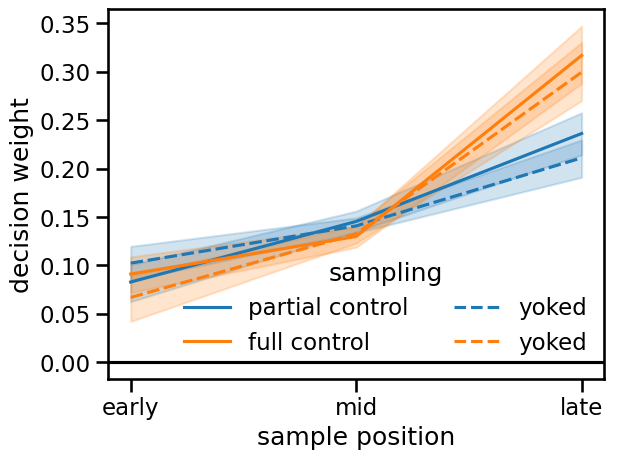

In [70]:
with sns.plotting_context("talk", font_scale=1):
    fig, ax = plt.subplots()
    sns.lineplot(
        x="timing",
        y="slope",
        hue="stopping",
        hue_order=["fixed", "variable"],
        style="sampling",
        style_order=["active", "yoked"],
        data=decision_weight_df,
        ci=68,
        ax=ax,
        legend=False,
    )

    ax.axhline(0, color="black")
    ax.set_ylabel("decision weight")
    ax.set_xlabel("sample position")

    # add legend
    # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
    legend_elements = []
    for linestyle in ["-", "--"]:
        for i, label in enumerate(["partial control", "full control"]):

            if linestyle == "--":
                label = "yoked"

            color = sns.color_palette()[i]
            legend_elements.append(
                Line2D(
                    [0], [0], color=color, marker=None, label=label, linestyle=linestyle
                ),
            )

    # define invisible bogus item to tweak legend
    # bogus_item = Line2D([0], [0], color="white", marker=None, label="", linestyle=linestyle)
    # legend_elements.insert(2, bogus_item)

    legend1 = fig.legend(
        handles=legend_elements,
        loc="lower right",
        bbox_to_anchor=(0.95, 0.175),
        framealpha=1,
        frameon=False,
        ncol=2,
        title="sampling",
    )


## `late - early`

In [71]:
flip = 0
selection = "timing_task"
subjdfs = []
for subj in range(1, 41):
    # calculate
    coef = get_log_reg_coef(tmp_logreg, subj, flip, selection)

    colnames = {
        "all": ["data_used"],
        "timing": ["timing"],
        "task": ["sampling"],
        "timing_task": ["sampling", "timing"],
    }[selection]

    # "save"
    tmp_subjdf = pd.DataFrame(np.array([i.split("/") for i in list(coef.keys())]))
    tmp_subjdf.columns = colnames
    tmp_subjdf["slope"] = np.array(list(coef.values()))
    tmp_subjdf["subject"] = subj
    tmp_subjdf = tmp_subjdf[["subject", *colnames, "slope"]]
    subjdfs.append(tmp_subjdf)

decision_weight_df = pd.concat(subjdfs)

# sampling column must be capitalized to match with "tmp" df that we want
# to merge on this df
decision_weight_df["sampling"] = decision_weight_df["sampling"].str.capitalize()

decision_weight_df.head()

,subject,sampling,timing,slope
0,1,Active,early,0.265003
1,1,Active,mid,0.189352
2,1,Active,late,0.127329
3,1,Yoked,early,0.285961
4,1,Yoked,mid,0.199411


In [72]:
# get stopping and task factors back
tmp = pd.read_csv(op.join(BIDS_ROOT, "participants.tsv"), sep="\t")
tmp["subject"] = [int(i[-2:]) for i in tmp["participant_id"]]
tmp = tmp[["subject", "stopping"]]
tmp["stopping"] = tmp["stopping"].str.capitalize()

decision_weight_df = decision_weight_df.merge(tmp, on=["subject"])

decision_weight_df["task"] = (
    decision_weight_df["sampling"].str[0] + decision_weight_df["stopping"].str[0]
).str.upper()


decision_weight_df.head()

,subject,sampling,timing,slope,stopping,task
0,1,Active,early,0.265003,Fixed,AF
1,1,Active,mid,0.189352,Fixed,AF
2,1,Active,late,0.127329,Fixed,AF
3,1,Yoked,early,0.285961,Fixed,YF
4,1,Yoked,mid,0.199411,Fixed,YF


In [73]:
# subtract second from first --> first - second
first = "late"
second = "early"
colname = f"slope_{first}_minus_{second}"
tmp_dwdf = decision_weight_df[decision_weight_df["timing"] == first].merge(
    decision_weight_df[decision_weight_df["timing"] == second],
    on=["subject", "task"],
    suffixes=("_" + first, "_" + second),
)
tmp_dwdf.insert(0, colname, tmp_dwdf[f"slope_{first}"] - tmp_dwdf[f"slope_{second}"])

tmp_dwdf["sampling"] = [
    "Active" if i.startswith("A") else "Yoked" for i in tmp_dwdf["task"]
]
tmp_dwdf["stopping"] = [
    "Fixed" if i.endswith("F") else "Variable" for i in tmp_dwdf["task"]
]

tmp_dwdf.head()

,slope_late_minus_early,subject,sampling_late,timing_late,slope_late,stopping_late,task,sampling_early,timing_early,slope_early,stopping_early,sampling,stopping
0,-0.137674,1,Active,late,0.127329,Fixed,AF,Active,early,0.265003,Fixed,Active,Fixed
1,-0.156186,1,Yoked,late,0.129775,Fixed,YF,Yoked,early,0.285961,Fixed,Yoked,Fixed
2,0.172635,2,Active,late,0.368053,Variable,AV,Active,early,0.195417,Variable,Active,Variable
3,0.072882,2,Yoked,late,0.285616,Variable,YV,Yoked,early,0.212734,Variable,Yoked,Variable
4,0.210141,3,Active,late,0.257065,Fixed,AF,Active,early,0.046924,Fixed,Active,Fixed


### correlate recency with numeracy

In [74]:
bnt_recency_corr_df = bnt_acc_corr_df.merge(
    tmp_dwdf.groupby(["subject"])[colname].mean().reset_index(), on="subject"
)
bnt_recency_corr_df = bnt_recency_corr_df.rename(columns={colname: "recency"})

In [75]:
pingouin.correlation.corr(
    bnt_recency_corr_df["recency"],
    bnt_recency_corr_df["bnt_quartile"],
    tail="one-sided",
    method="kendall",
).round(3)

,n,r,CI95%,p-val,power
kendall,40,-0.099,"[-0.4, 0.22]",0.208,0.151


In [76]:
# save data for publication plots
plotdir = op.join(BIDS_ROOT, "code", "publication_plots")
os.makedirs(plotdir, exist_ok=True)

fname = "beh_recency_logreg.csv"
fname = op.join(plotdir, fname)

tmp_dwdf.to_csv(fname, index=False)

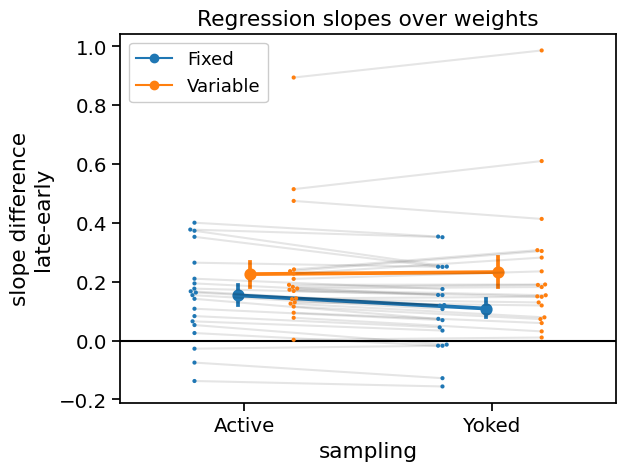

In [77]:
with sns.plotting_context("notebook", font_scale=1.3):
    fig, ax = plt.subplots()

    sns.pointplot(
        x="sampling",
        y=colname,
        hue="stopping",
        data=tmp_dwdf,
        dodge=True,
        ci=68,
        hue_order=["Fixed", "Variable"],
        ax=ax,
        markers="o",
    )

    sns.swarmplot(
        x="sampling",
        y=colname,
        hue="stopping",
        data=tmp_dwdf,
        hue_order=["Fixed", "Variable"],
        ax=ax,
        dodge=True,
        size=3,
    )

    # add legend
    # https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D([0], [0], color=sns.color_palette()[0], marker="o", label="Fixed"),
        Line2D([0], [0], color=sns.color_palette()[1], marker="o", label="Variable"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper left",
        prop={"size": 13},
        framealpha=1,
    )

    ax.set_ylabel(f"slope difference\n{first}-{second}")

    # https://stackoverflow.com/a/51157346/5201771
    # 2-4 3-5
    for idx0, idx1 in [(2, 4), (3, 5)]:
        locs1 = ax.get_children()[idx0].get_offsets()
        locs2 = ax.get_children()[idx1].get_offsets()

        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, color="black", alpha=0.1)

    ax.axhline(0, color="black")
    ax.set_title("Regression slopes over weights")

In [78]:
model = pingouin.mixed_anova(
    data=tmp_dwdf, dv=colname, within="sampling", subject="subject", between="stopping"
)
model.round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,stopping,0.193,1,38,0.193,3.363,0.075,0.081,NaN
1,sampling,0.007,1,38,0.007,0.800,0.377,0.021,1.0
2,Interaction,0.013,1,38,0.013,1.483,0.231,0.038,NaN


In [79]:
stats = pingouin.pairwise_ttests(
    data=tmp_dwdf,
    dv=colname,
    within="sampling",
    between="stopping",
    subject="subject",
    padjust="bonf",
    within_first=False,
    effsize="cohen",
)

display(stats.round(3))

,Contrast,stopping,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,stopping,-,Fixed,Variable,False,True,-1.834,38.0,two-sided,0.075,NaN,NaN,1.143,-0.580
1,sampling,-,Active,Yoked,True,True,0.889,39.0,two-sided,0.379,NaN,NaN,0.247,0.101
2,stopping * sampling,Fixed,Active,Yoked,True,True,1.540,19.0,two-sided,0.140,0.28,bonf,0.64,0.308
3,stopping * sampling,Variable,Active,Yoked,True,True,-0.222,19.0,two-sided,0.827,1.00,bonf,0.238,-0.032
